In [1]:
from __future__ import print_function, division
import os
from PIL import Image
import pandas as pd


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

In [4]:
from torchvision import transforms
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

vgg16 = models.vgg16_bn()
for param in vgg16.features.parameters():
    param.require_grad = False
class_names = ['other', 'cloud','smoke']

num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

# vgg16.load_state_dict(torch.load('/home/jszumny/Documents/copy of smoke data/newnew/attempts/3features/fullmodelbest.pt',map_location=torch.device('cpu')))

resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
num_features = resnet18.fc.in_features     #extract fc layers features
resnet18.fc = nn.Linear(num_features, 2) #(num_of_class == 2)

resnet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
num_features = resnet34.fc.in_features     #extract fc layers features
resnet34.fc = nn.Linear(num_features, 2) #(num_of_class == 2)

resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
num_features = resnet50.fc.in_features     #extract fc layers features
resnet50.fc = nn.Linear(num_features, 2) #(num_of_class == 2)


Using cache found in /home/jszumny/.cache/torch/hub/pytorch_vision_v0.10.0
/home/jszumny/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jszumny/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /home/jszumny/.cache/torch/hub/pytorch_vision_v0.10.0
/home/jszumny/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the

In [4]:
dir = "/home/jszumny/Arm Data/"

data = []
for file in os.listdir(dir):
    
    for image in os.listdir(dir +file):

        fullimage = Image.open(dir + "/" +  file + "/" +image)
        fullimage = fullimage.resize((1344, 1120))

        for i in range(6):
            for k in range(5):
                
                tile = fullimage.crop((i*224, k*224, (i+1)*224, (k+1)*224))
                
                vgg16.load_state_dict(torch.load('/home/jszumny/Documents/copy of smoke data/newnew/attempts/2features/2featuresVGG16model.pt',map_location=torch.device('cpu')))

                img_t = transform(tile)
                batch_t = torch.unsqueeze(img_t, 0)

                vgg16.eval()
                out = vgg16(batch_t)
            
                _, index = torch.max(out, 1)
            
                percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
                
                d = {"filepath": dir+file+image, "tilenum": str(i) + str(k),"class": class_names[index[0]], "percentage": percentage[index[0]].item()}
                data.append(d)

KeyboardInterrupt: 

In [7]:
df = pd.DataFrame(data)

df[df['class']=='smoke']


,filepath,tilenum,class,percentage


In [8]:
len(df[df["class"] == 'smoke'])/len(df)

0.14156735283495847

In [ ]:
df[df['class']=='smoke']


,filepath,tilenum,class,percentage
0,/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20...,00,smoke,70.337746
5,/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20...,10,smoke,89.789162
6,/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20...,11,smoke,98.951363
10,/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20...,20,smoke,65.970024
11,/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20...,21,smoke,77.337868
...,...,...,...,...
1211,/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20...,21,smoke,60.195953
1215,/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20...,30,smoke,54.713535
1220,/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20...,40,smoke,66.217506
1221,/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20...,41,smoke,80.955437


3 FEATURES
VGG16 - 20% FPR                 
Resnet18 - 3% FPR                   
Resnet34 - 14% FPR                  
Resnet50 - 0% FPR   NO TRUE POSITIVES   

UCSD - 6% FPR

In [5]:
dir = "/home/jszumny/Downloads/"


from PIL import Image
import io

fullimage = Image.open("/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20221001.001123.jpg/enatwrcamtarmacC1.a1.20221001.153223.jpg")
fullimage = fullimage.resize((2688, 2240))


def transform_image(image_bytes):
    my_transforms = transforms.Compose([transforms.Resize(255),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)
vgg16 = models.vgg16_bn()

resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
num_features = resnet50.fc.in_features     #extract fc layers features
resnet50.fc = nn.Linear(num_features, 3) #(num_of_class == 2)

resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
num_features = resnet18.fc.in_features     #extract fc layers features
resnet18.fc = nn.Linear(num_features, 3) #(num_of_class == 2)

resnet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
num_features = resnet34.fc.in_features     #extract fc layers features
resnet34.fc = nn.Linear(num_features, 3) #(num_of_class == 2)

for param in vgg16.features.parameters():
    param.require_grad = False
class_names = ["cloud", "other", "smoke"]

num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    output = vgg16.forward(tensor)
     
    probs = torch.nn.functional.softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)
    print(classes.item())
    return conf.item(), class_names[classes.item()]


data = []
dir = "/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20221001.001123.jpg/"
imagetime = 0
for image in os.listdir(dir):
    if (int(image[30:36]) >= 144600) & (int(image[30:36]) <= 154600):
        imagetime = image[30:36]
        fullimage = Image.open(dir + image)
        fullimage = fullimage.resize((2688, 2240))
        

        for i in range(12):
            for k in range(10):
                vgg16.load_state_dict(torch.load('/home/jszumny/Documents/copy of smoke data/newnew/attempts/difference/difference.pt',map_location=torch.device('cpu')))

                vgg16.eval()

                tile = fullimage.crop((i*224, k*224, (i+1)*224, (k+1)*224))
                tile.save('/home/jszumny/Documents/test/' + str(i) + str(k) + '.jpg')
                

                image_path= "/home/jszumny/Documents/test/" + str(i) + str(k) + '.jpg'
                image = plt.imread(image_path)
                plt.imshow(image)
                
                with open(image_path, 'rb') as f:
                    image_bytes = f.read()
                    
                    conf,y_pre=get_prediction(image_bytes=image_bytes)
                    print(y_pre, ' at confidence score:{0:.2f}'.format(conf))
            
                d = {"imagetime": imagetime,"tilenum": str(i) + str(k),"class": y_pre, "percentage": '{0:.2f}'.format(conf)}
                data.append(d)

Using cache found in /home/jszumny/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/jszumny/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/jszumny/.cache/torch/hub/pytorch_vision_v0.10.0


KeyboardInterrupt: 

Using cache found in /home/jszumny/.cache/torch/hub/pytorch_vision_v0.10.0
/home/jszumny/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jszumny/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /home/jszumny/.cache/torch/hub/pytorch_vision_v0.10.0
/home/jszumny/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the

1
other  at confidence score:0.66
1
other  at confidence score:0.96
1
other  at confidence score:0.94
1
other  at confidence score:0.63
2
smoke  at confidence score:0.99
1
other  at confidence score:0.94
1
other  at confidence score:0.98
1
other  at confidence score:0.97
2
smoke  at confidence score:0.75
1
other  at confidence score:0.99
1
other  at confidence score:0.93
1
other  at confidence score:0.99
2
smoke  at confidence score:0.92
1
other  at confidence score:0.99
1
other  at confidence score:0.86
1
other  at confidence score:0.97
2
smoke  at confidence score:0.71
1
other  at confidence score:0.99
1
other  at confidence score:0.97
1
other  at confidence score:0.76
2
smoke  at confidence score:0.92
1
other  at confidence score:0.98
1
other  at confidence score:0.98
1
other  at confidence score:0.87
1
other  at confidence score:0.59
1
other  at confidence score:0.97
1
other  at confidence score:0.99
1
other  at confidence score:0.82
2
smoke  at confidence score:0.97
1
other  at co

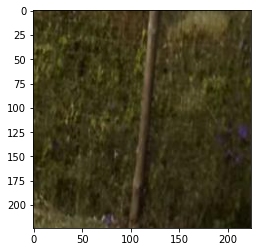

In [20]:
dir = "/home/jszumny/Downloads/"


from PIL import Image, ImageChops
import io

fullimage = Image.open("/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20221001.001123.jpg/enatwrcamtarmacC1.a1.20221001.153223.jpg")
fullimage = fullimage.resize((2688, 2240))


def transform_image(image_bytes):
    my_transforms = transforms.Compose([transforms.Resize(255),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)
vgg16 = models.vgg16_bn()

resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
num_features = resnet50.fc.in_features     #extract fc layers features
resnet50.fc = nn.Linear(num_features, 3) #(num_of_class == 2)

resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
num_features = resnet18.fc.in_features     #extract fc layers features
resnet18.fc = nn.Linear(num_features, 3) #(num_of_class == 2)

resnet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
num_features = resnet34.fc.in_features     #extract fc layers features
resnet34.fc = nn.Linear(num_features, 3) #(num_of_class == 2)

for param in vgg16.features.parameters():
    param.require_grad = False
class_names = ["cloud", "other", "smoke"]

num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    output = vgg16.forward(tensor)
     
    probs = torch.nn.functional.softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)
    print(classes.item())
    return conf.item(), class_names[classes.item()]


data = []
dir = "/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20221001.001123.jpg/"
imagetime = 0
for image in os.listdir(dir):
    if (int(image[30:36]) >= 144400) & (int(image[30:36]) <= 155000) & (int(image[32:34]) % 5 == 0):
    # if (((int(image[30:36]) >= 73000) & (int(image[30:36]) <= 142000)) | 
    #     ((int(image[30:36]) >= 155600) & (int(image[30:36]) <= 193000))) & (int(image[32:34]) % 5 == 0) :
        imagetime = image[30:36]
        fullimage = Image.open(dir + image)
        fullimage = fullimage.resize((1344, 1344))
        fullimage = fullimage.crop((0, 448, 1344, 1344))
        

        for i in range(6):
            for k in range(4):
                vgg16.load_state_dict(torch.load('/home/jszumny/Documents/copy of smoke data/newnew/attempts/3features/fullmodelbest.pt',map_location=torch.device('cpu')))

                vgg16.eval()

                tile = fullimage.crop((i*224, k*224, (i+1)*224, (k+1)*224))
                # tile = ImageChops.invert(tile)
                tile.save('/home/jszumny/Documents/test/' + str(i) + "_" + str(k) + '.jpg')
                

                image_path= ("/home/jszumny/Documents/test/" + str(i) + "_" + str(k) + '.jpg')
                image = plt.imread(image_path)
                plt.imshow(image)
                
                with open(image_path, 'rb') as f:
                    image_bytes = f.read()
                    
                    conf,y_pre=get_prediction(image_bytes=image_bytes)
                    print(y_pre, ' at confidence score:{0:.2f}'.format(conf))
            
                d = {"imagetime": imagetime,"xtile": str(i), "ytile": str(k),"class": y_pre, "percentage": '{0:.2f}'.format(conf)}
                data.append(d)

In [23]:
import pandas as pd
smoke = pd.DataFrame(data)
smoke
smoke.to_csv("smoke.csv")

In [22]:
new = smoke[smoke['class']=='smoke']
new

,imagetime,xtile,ytile,class,percentage
4,153023,1,0,smoke,0.99
8,153023,2,0,smoke,0.75
12,153023,3,0,smoke,0.92
16,153023,4,0,smoke,0.71
20,153023,5,0,smoke,0.92
28,145023,1,0,smoke,0.97
32,145023,2,0,smoke,0.92
36,145023,3,0,smoke,0.97
40,145023,4,0,smoke,0.49
52,154523,1,0,smoke,0.97


In [18]:
smoke = df[(df['xtile'] == '1') & (df['ytile'] == '0')]
smoke

,imagetime,xtile,ytile,class,percentage
4,131723,1,0,smoke,0.93
28,141223,1,0,smoke,0.98
52,135923,1,0,smoke,0.93
76,133623,1,0,smoke,0.96
100,135523,1,0,smoke,0.93
...,...,...,...,...,...
2140,124723,1,0,smoke,0.99
2164,130623,1,0,smoke,0.90
2188,140323,1,0,smoke,0.96
2212,134823,1,0,smoke,0.98


In [46]:
smoke

,imagetime,xtile,ytile,class,percentage


In [26]:
df.to_csv("ArmSmokeDetection.csv")

In [9]:
tile00  = df[df["tilenum"] == '00']
tile00

KeyError: 'tilenum'

In [15]:
tile00[tile00['class']=='smoke']

,imagetime,tilenum,class,percentage
0,153023,00,smoke,0.55
240,145023,00,smoke,0.95
360,150723,00,smoke,0.90
480,152623,00,smoke,0.83
600,154523,00,smoke,0.62


In [18]:
df[df['class']=='smoke']

,imagetime,tilenum,class,percentage
0,153023,00,smoke,0.55
1,153023,01,smoke,0.69
2,153023,02,smoke,0.89
3,153023,03,smoke,0.97
10,153023,10,smoke,0.84
...,...,...,...,...
664,154523,64,smoke,0.68
670,154523,70,smoke,0.94
671,154523,71,smoke,0.97
672,154523,72,smoke,0.89


In [19]:
smoke = df[df['class'] == 'smoke']
len(smoke[(smoke.tilenum == '34') | (smoke.tilenum == '44') ]) / len(smoke)

0.009216589861751152

In [20]:
smoke[(smoke.tilenum == '34') | (smoke.tilenum == '44') ]

,imagetime,tilenum,class,percentage
154,151123,34,smoke,0.72
274,145023,34,smoke,0.77


In [24]:
df.to_csv("Resnet34ARM")

In [3]:
dir = "/home/jszumny/Downloads/"


from PIL import Image
import io
import os


def transform_image(image_bytes):
    my_transforms = transforms.Compose([transforms.Resize(255),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)



def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    output = vgg16.forward(tensor)
     
    probs = torch.nn.functional.softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)
    print(classes.item())
    return conf.item(), class_names[classes.item()]

def mse(img1, img2):
   h, w = img1.shape
   diff = cv2.subtract(img1, img2)
   err = np.sum(diff**2)
   mse = err/(float(h*w))
   return mse, diff



import cv2

data = []
dir = "/home/jszumny/Documents/split/"

list = []
for image in sorted(os.listdir(dir)):
    list.append(image)
list

['enatwrcamtarmacC1.a1.20221001.144623.jpg_0_0.jpg',
 'enatwrcamtarmacC1.a1.20221001.144623.jpg_0_1.jpg',
 'enatwrcamtarmacC1.a1.20221001.144623.jpg_0_2.jpg',
 'enatwrcamtarmacC1.a1.20221001.144623.jpg_0_3.jpg',
 'enatwrcamtarmacC1.a1.20221001.144623.jpg_0_4.jpg',
 'enatwrcamtarmacC1.a1.20221001.144623.jpg_0_5.jpg',
 'enatwrcamtarmacC1.a1.20221001.144623.jpg_0_6.jpg',
 'enatwrcamtarmacC1.a1.20221001.144623.jpg_0_7.jpg',
 'enatwrcamtarmacC1.a1.20221001.144623.jpg_0_8.jpg',
 'enatwrcamtarmacC1.a1.20221001.144623.jpg_0_9.jpg',
 'enatwrcamtarmacC1.a1.20221001.144623.jpg_10_0.jpg',
 'enatwrcamtarmacC1.a1.20221001.144623.jpg_10_1.jpg',
 'enatwrcamtarmacC1.a1.20221001.144623.jpg_10_2.jpg',
 'enatwrcamtarmacC1.a1.20221001.144623.jpg_10_3.jpg',
 'enatwrcamtarmacC1.a1.20221001.144623.jpg_10_4.jpg',
 'enatwrcamtarmacC1.a1.20221001.144623.jpg_10_5.jpg',
 'enatwrcamtarmacC1.a1.20221001.144623.jpg_10_6.jpg',
 'enatwrcamtarmacC1.a1.20221001.144623.jpg_10_7.jpg',
 'enatwrcamtarmacC1.a1.20221001.144623

In [7]:
list00 = []
for i in range(len(list)):
    
    if ".jpg_0_0.jpg" in list[i]:
        
        list00.append(list[i])


        # img1 = cv2.imread(dir + list[i])
        # img2 = cv2.imread(dir + list[i-1])
        # img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        # img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

        # error, diff = mse(img1, img2)

        # cv2.imwrite("/home/jszumny/Documents/copy of smoke data/newnew/diffsmoke/" + list[i], diff)

In [29]:
import numpy as np

list00 = []
for i in range(len(list)):
    
    if ".jpg_2_9.jpg" in list[i]:
        
        list00.append(list[i])


dir = "/home/jszumny/Documents/split/"
for i in range(len(list00)):
    
    if "144623" not in list00[i]:
        
        img1 = cv2.imread(dir + list00[i])
        img2 = cv2.imread(dir + list00[i-1])
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

        error, diff = mse(img1, img2)

        cv2.imwrite("/home/jszumny/Documents/diffsplit/" + list00[i], diff)

In [31]:
for j in range(12):
    for k in range(10):
        list00 = []
        for i in range(len(list)):
            
            if (".jpg_" + str(j) + "_" + str(k) + ".jpg") in list[i]:
                
                list00.append(list[i])


        dir = "/home/jszumny/Documents/split/"
        for i in range(len(list00)):
            
            if "144623" not in list00[i]:
                
                img1 = cv2.imread(dir + list00[i])
                img2 = cv2.imread(dir + list00[i-1])
                img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
                img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

                error, diff = mse(img1, img2)

                cv2.imwrite("/home/jszumny/Documents/diffsplit/" + list00[i], diff)

In [13]:
dir = '/home/jszumny/Documents/diffsplit/'
for tile in os.listdir(dir):

    new = Image.open(dir + tile).convert('RGB') 
    new.save(dir+tile)

0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at confidence score:1.00
0
cloud  at co

KeyboardInterrupt: 

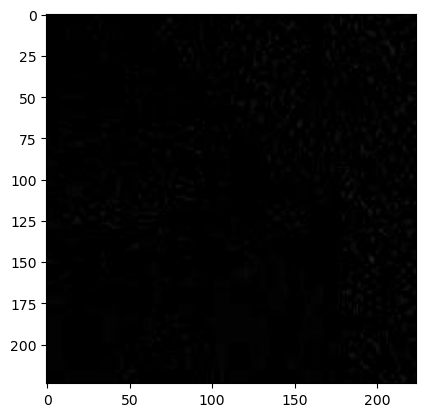

In [17]:
dir = "/home/jszumny/Downloads/"


from PIL import Image
import io
import cv2



def transform_image(image_bytes):
    my_transforms = transforms.Compose([transforms.Resize(255),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)

vgg16 = models.vgg16_bn()


for param in vgg16.features.parameters():
    param.require_grad = False

class_names = ["cloud", "other", "smoke"]


num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier


def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    output = vgg16.forward(tensor)
     
    probs = torch.nn.functional.softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)
    print(classes.item())
    return conf.item(), class_names[classes.item()]


data = []

dir = '/home/jszumny/Documents/diffsplit/'
for tile in os.listdir(dir):
        
        vgg16.load_state_dict(torch.load('/home/jszumny/Documents/copy of smoke data/newnew/attempts/difference/difference.pt',map_location=torch.device('cpu')))

        vgg16.eval()

        
        image_path= dir + tile

        image = plt.imread(image_path)
        
        
        plt.imshow(image)
        
        with open(image_path, 'rb') as f:
            image_bytes = f.read()
            
            conf,y_pre=get_prediction(image_bytes=image_bytes)
            print(y_pre, ' at confidence score:{0:.2f}'.format(conf))

        imagetime = tile[30:36]
        tilenum = tile[40:44]
        d = {"imagetime": imagetime,"tilenum": tilenum,"class": y_pre, "percentage": '{0:.2f}'.format(conf)}
        data.append(d)

In [20]:
df = pd.DataFrame(data)
df[df["class"] == "cloud"]

,imagetime,tilenum,class,percentage
0,153723,_10_,cloud,1.00
1,150823,_9_5,cloud,1.00
2,150223,_3_8,cloud,1.00
3,150023,_9_3,cloud,1.00
4,152923,_10_,cloud,1.00
...,...,...,...,...
539,145523,_10_,cloud,1.00
540,152223,_6_5,cloud,1.00
541,153823,_0_2,cloud,1.00
542,152623,_6_6,cloud,1.00


In [1]:


from PIL import Image, ImageChops
 
# Opening the test image, and saving it's object
image = Image.open("/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20221001.001123.jpg/enatwrcamtarmacC1.a1.20221001.145623.jpg")
 
# Passing the image object to invert() 
inv_img = ImageChops.invert(image)
 
# Displaying the output image
inv_img.show()

In [25]:
dir = "/home/jszumny/Documents/split/"
for image in os.listdir(dir):
    dir = "/home/jszumny/Documents/split/"
    img = Image.open(dir + image)
    img = ImageChops.invert(img)
    dir = "/home/jszumny/Documents/colorsplit/"
    img.save(dir + image)